# Loading in some data

The below cell loads in a geodata frame -- this is like a fancy excel spreadsheet (a.k.a. pandas dataframe), where each row of the spreadsheet contains information of a precinct in Texas.

Let's print out the first 5 rows of this dataframe to see what kind of data it contains.

In [1]:
import geopandas as gpd

precinct_gdf = gpd.read_file("data/TX_precincts_24/TX_precincts24_with_pop.shp")
# fill nan values in VAP20 with 0
precinct_gdf["VAP20"] = precinct_gdf["VAP20"].fillna(0)
precinct_gdf.head(5)

,PRECINCT,COUNTY,CD25,Incumbent2,TOTPOP20,VAP20,BVAP20,HVAP20,AAPIVAP20,AMINVAP20,WVAP20,DVAP22,BDVAP22,HDVAP22,AAPIDVAP22,AMINDVAP22,WDVAP22,geometry
0,1890420,189,19,0,576.0,445.0,4.0,108.0,4.0,3.0,326.0,415.476431,3.977186,93.851003,4.000000,3.000000,310.648241,"POLYGON ((226335.861 3790308.843, 226333.648 3..."
1,1890419,189,19,0,460.0,322.0,0.0,111.0,3.0,3.0,205.0,290.361465,0.000000,92.753425,3.000000,3.000000,191.608040,"POLYGON ((226333.648 3790236.182, 226335.861 3..."
2,1890304,189,19,0,1503.0,1077.0,67.0,476.0,18.0,12.0,504.0,990.184097,63.823529,406.286882,7.230769,9.785325,503.057592,"POLYGON ((248062.528 3787449.003, 248193.83 37..."
3,1890306,189,19,0,214.0,142.0,17.0,82.0,3.0,3.0,37.0,138.702145,17.000000,79.255814,3.000000,2.446331,37.000000,"POLYGON ((247760.43 3786634.764, 247783.302 37..."
4,650402,65,13,0,408.0,323.0,4.0,13.0,1.0,14.0,291.0,319.265423,4.000000,13.000000,0.667201,11.416212,290.182010,"POLYGON ((292770.184 3944754.408, 293383.841 3..."


Each column carries some demographic information about the precincts: for example, "VAP20" stands for the Voting Age Population recorded by the 2020 census in each precinct, and "BVAP20" stands for the recorded Black Voting Age Population.

Because this is a *__geo__*dataframe, the last column carries information about the geometry of each precinct, which we can use to plot the full map of Texas precincts:

<Axes: >

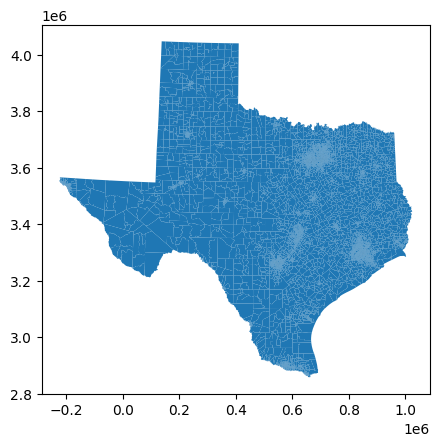

In [2]:
precinct_gdf.plot()

Let's also load in the proposed 2025 redistricting -- this is a partition of Texas's precincts into 38 congressional districts. 

Number of NaN values replaced with 0: 74
Adding 30 edges to connect district 11
Adding 5 edges to connect district 12
Adding 15 edges to connect district 10
Adding 5 edges to connect district 20
Adding 5 edges to connect district 29
Adding 5 edges to connect district 2


<Axes: >

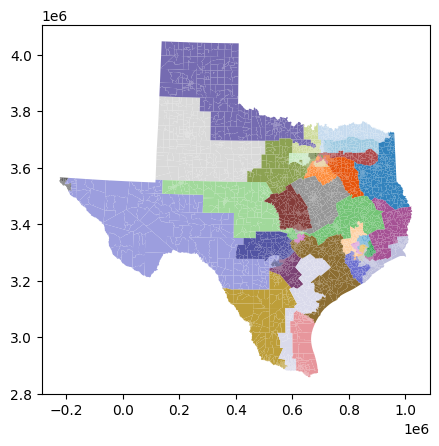

In [3]:
from gerrychain import Graph, Partition
from gerrychain.updaters import Tally
from src.custom_cmap import custom_cmap
from src.partition_contiguator import contiguate

tx_graph = Graph.from_json("data/TX_precincts_24/TX_precincts24_with_pop_and_elections.json")

tx_partition = Partition(tx_graph, assignment="CD25", updaters={"VAP": Tally("VAP20", alias="VAP20")})

number_of_nans = 0
for node in tx_graph.nodes:
    if tx_graph.nodes[node]["VAP20"] != tx_partition.graph.nodes[node]["VAP20"]:
        tx_graph.nodes[node]["VAP20"] = 0
        number_of_nans += 1
    if tx_graph.nodes[node]["BVAP20"] != tx_partition.graph.nodes[node]["BVAP20"]:
        tx_graph.nodes[node]["BVAP20"] = 0
    if tx_graph.nodes[node]["HVAP20"] != tx_partition.graph.nodes[node]["HVAP20"]:
        tx_graph.nodes[node]["HVAP20"] = 0
    if tx_graph.nodes[node]["HarrisD_PRSG24"] != tx_partition.graph.nodes[node]["HarrisD_PRSG24"]:
        tx_graph.nodes[node]["HarrisD_PRSG24"] = 0
    if tx_graph.nodes[node]["TrumpR_PRSG24"] != tx_partition.graph.nodes[node]["TrumpR_PRSG24"]:
        tx_graph.nodes[node]["TrumpR_PRSG24"] = 0
print(f"Number of NaN values replaced with 0: {number_of_nans}")
modified_tx_graph = contiguate(tx_graph, tx_partition)

tx_partition = Partition(modified_tx_graph, assignment="CD25", updaters={"VAP": Tally("VAP20", alias="VAP20")})

tx_partition.plot(geometries=precinct_gdf, cmap = custom_cmap)

# Running a Recom Markov Chain

Recombination is a way to use a current districting to draw a new one -- we merge two districts together, then split them up into two new districts in a smart way. If we do this many times, we can generate an ensemble of plans to compare to the 2025 map.

In [4]:
from gerrychain import MarkovChain
from gerrychain.constraints import contiguous
from gerrychain.proposals import recom
from gerrychain.accept import always_accept
from functools import partial
from gerrychain.tree import bipartition_tree

partition_len = len(tx_partition)
ideal_population = sum(tx_partition["VAP"].values()) / partition_len

proposal = partial(
    recom,
    pop_col="VAP20",
    pop_target=ideal_population,
    epsilon=0.05,
    node_repeats=10,
    method = partial(
        bipartition_tree,
        max_attempts = 100,
        allow_pair_reselection = True
    )
)

burnin_chain = MarkovChain(
    proposal=proposal,
    constraints=[contiguous],
    accept=always_accept,
    initial_state=tx_partition,
    total_steps=100
)

for i, item in enumerate(burnin_chain):
    print(f"Finished burn-in step {i+1}/{len(burnin_chain)}", end="\r")
print(f"Finished burn-in step {i+1}/{len(burnin_chain)}")
starting_partition = item

recom_chain = MarkovChain(
    proposal=proposal,
    constraints=[contiguous],
    accept=always_accept,
    initial_state=starting_partition,
    total_steps=1000
)

assignment_list = []

for i, item in enumerate(recom_chain):
    print(f"Finished step {i+1}/{len(recom_chain)}", end="\r")
    assignment_list.append(item.assignment)

Finished burn-in step 100/100


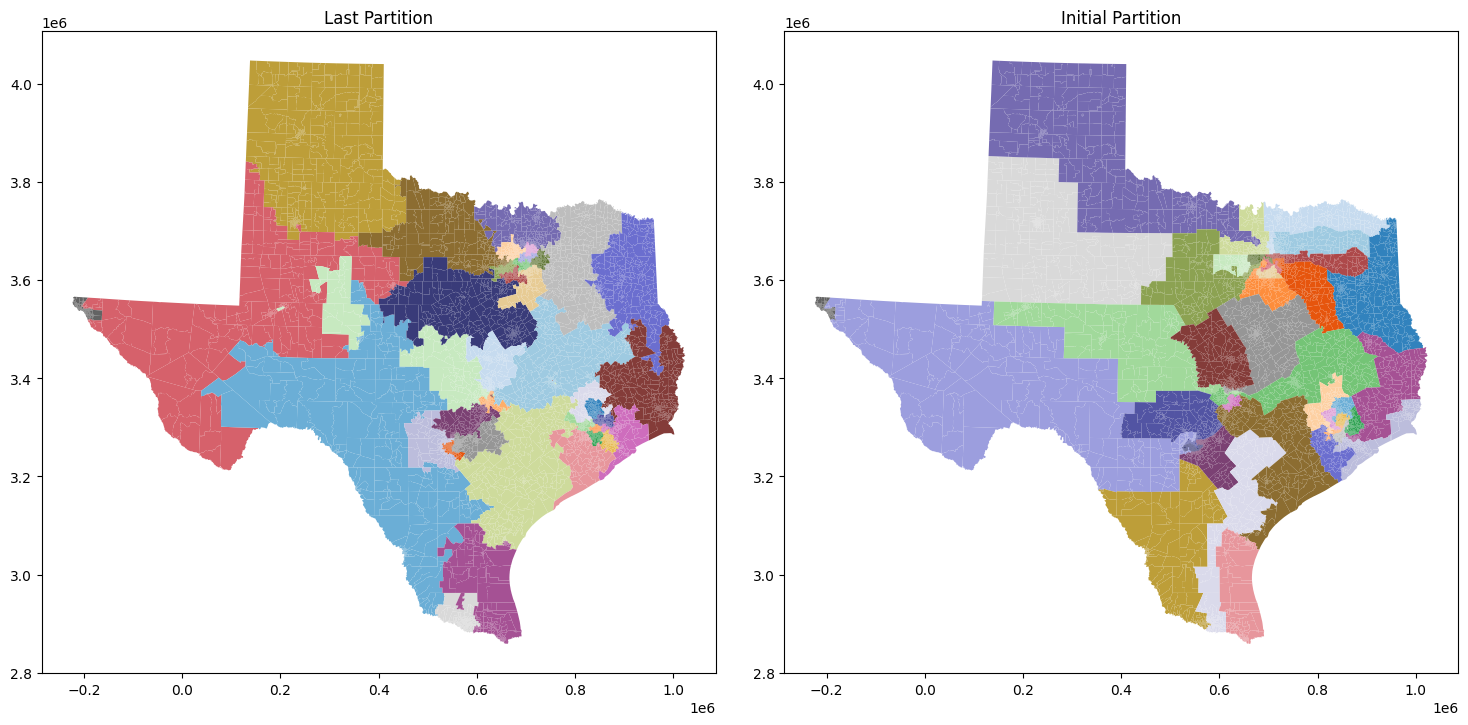

In [5]:
import matplotlib.pyplot as plt

last_assignment = assignment_list[-1]
last_partition = Partition(modified_tx_graph, assignment=last_assignment, updaters={"population": Tally("TOTPOP20", alias="population"), "VAP": Tally("VAP20", alias="VAP20")})
# plot them side by side with titles and unlabled axes
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
last_partition.plot(geometries=precinct_gdf, cmap = custom_cmap, ax=axes[0])
axes[0].set_title("Last Partition")
axes[0].set_xlabel("")
axes[0].set_ylabel("")
tx_partition.plot(geometries=precinct_gdf, cmap = custom_cmap, ax=axes[1])
axes[1].set_title("Initial Partition")
axes[1].set_xlabel("")
axes[1].set_ylabel("")
plt.tight_layout()
plt.show()

Now that we have an ensemble of maps, we can compare it to the enacted 2025 plan. Notice how the map "packs" and "cracks" democrat vote shares to maximize the number of safe republican districts. 

In particular, the 5 bars and whiskers that are plotted in red would typically be a democrat majority district in the "average" map in our ensemble, but the 2025 map turns them into safe republican districts.

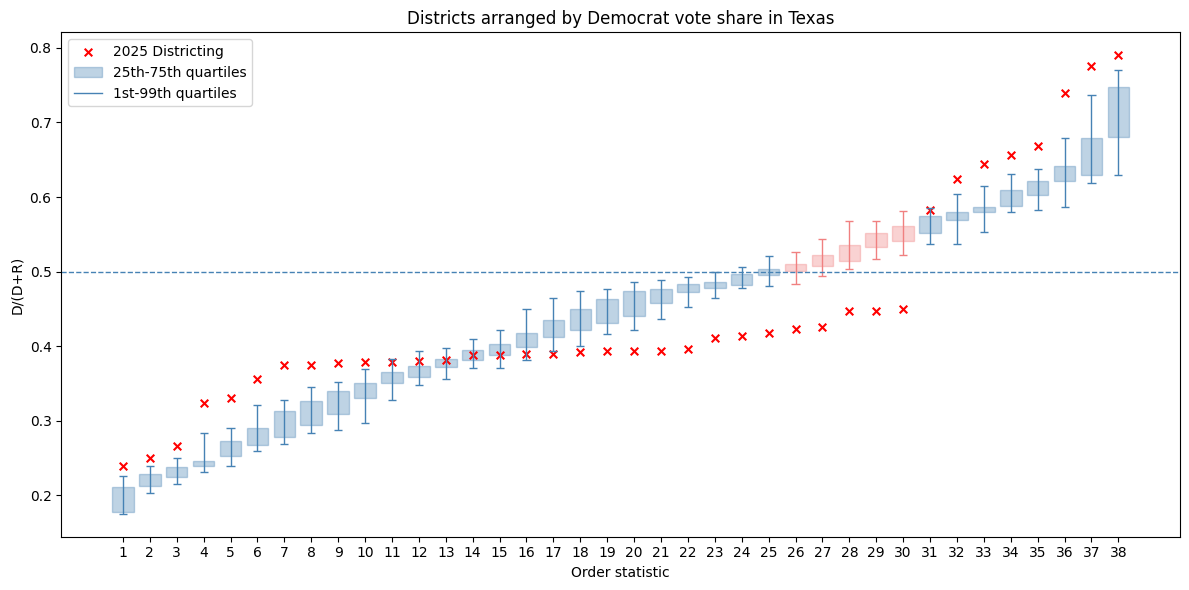

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Brute-force compute sorted D/(D+R) ratios for each assignment
ratios_per_assignment = []

# Parts are 1-indexed in this dataset
n_parts = len(tx_partition)
parts_list = list(range(1, n_parts + 1))

for assignment in assignment_list:
    # part -> [D, R]
    part_sums = {part: [0.0, 0.0] for part in parts_list}
    for node, part in assignment.mapping.items():
        data = modified_tx_graph.nodes[node]
        d = data.get("HarrisD_PRSG24", 0) or 0
        r = data.get("TrumpR_PRSG24", 0) or 0
        part_sums[part][0] += d
        part_sums[part][1] += r

    ratios = []
    for d, r in part_sums.values():
        total = d + r
        ratios.append(d / total if total else np.nan)

    ratios = np.array(ratios, dtype=float)
    # Sort low->high, keeping NaNs at the end
    ratios = np.sort(ratios)
    ratios_per_assignment.append(ratios)

# Stack into matrix: rows = assignments, cols = order stats
ratios_matrix = np.vstack(ratios_per_assignment)

q01 = np.nanpercentile(ratios_matrix, 1, axis=0)
q25 = np.nanpercentile(ratios_matrix, 25, axis=0)
q75 = np.nanpercentile(ratios_matrix, 75, axis=0)
q99 = np.nanpercentile(ratios_matrix, 99, axis=0)

x = np.arange(1, ratios_matrix.shape[1] + 1)

# Compute initial partition ratios for overlay
init_sums = {part: [0.0, 0.0] for part in parts_list}
for node, part in tx_partition.assignment.mapping.items():
    data = modified_tx_graph.nodes[node]
    d = data.get("HarrisD_PRSG24", 0) or 0
    r = data.get("TrumpR_PRSG24", 0) or 0
    init_sums[part][0] += d
    init_sums[part][1] += r

init_ratios = []
for d, r in init_sums.values():
    total = d + r
    init_ratios.append(d / total if total else np.nan)
init_ratios = np.sort(np.array(init_ratios, dtype=float))

plt.figure(figsize=(12, 6))

# Bar from 25th to 75th percentile
bar_heights = q75 - q25
# Color positions 26-30 (1-based) in light red
bar_colors = ["steelblue"] * len(x)
for i in range(25, 30):
    if 0 <= i < len(bar_colors):
        bar_colors[i] = "lightcoral"
plt.bar(x, bar_heights, bottom=q25, width=0.8, alpha=0.35, color=bar_colors, edgecolor=bar_colors, label="25th-75th quartiles")

# Whiskers from 1st to 99th percentile
whisker_colors = ["steelblue"] * len(x)
for i in range(25, 30):
    if 0 <= i < len(whisker_colors):
        whisker_colors[i] = "lightcoral"
for xi, lo, hi, c in zip(x, q01, q99, whisker_colors):
    plt.vlines(xi, lo, hi, colors=c, linewidth=1)
    plt.hlines([lo, hi], xi - 0.15, xi + 0.15, colors=c, linewidth=1)

# Initial partition overlay as red X
plt.scatter(x, init_ratios, color="red", marker="x", s=30, label="2025 Districting")

# Reference line at 0.5
plt.axhline(0.5, color="steelblue", linestyle="--", linewidth=1)

# Histogram-like x-axis ticks
plt.xticks(x)

plt.xlabel("Order statistic")
plt.ylabel("D/(D+R)")
plt.title("Districts arranged by Democrat vote share in Texas")

# Legend (add whisker handle)
whisker_handle = Line2D([0], [0], color="steelblue", linewidth=1, label="1st-99th quartiles")
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(whisker_handle)
labels.append("1st-99th quartiles")
plt.legend(handles, labels)

plt.tight_layout()
plt.show()

Of course, partisan gerrymandering is legal in Texas, so the above graph is not a smoking gun -- it's just a good illustrationg of what's going on.

What *is* currently illegal according to the VRA is to dilute the voting power of politically cohesive racial minority groups. So we can repeat the above plot, but showing the fractional vote share of Black and Hispanic voters in each district.

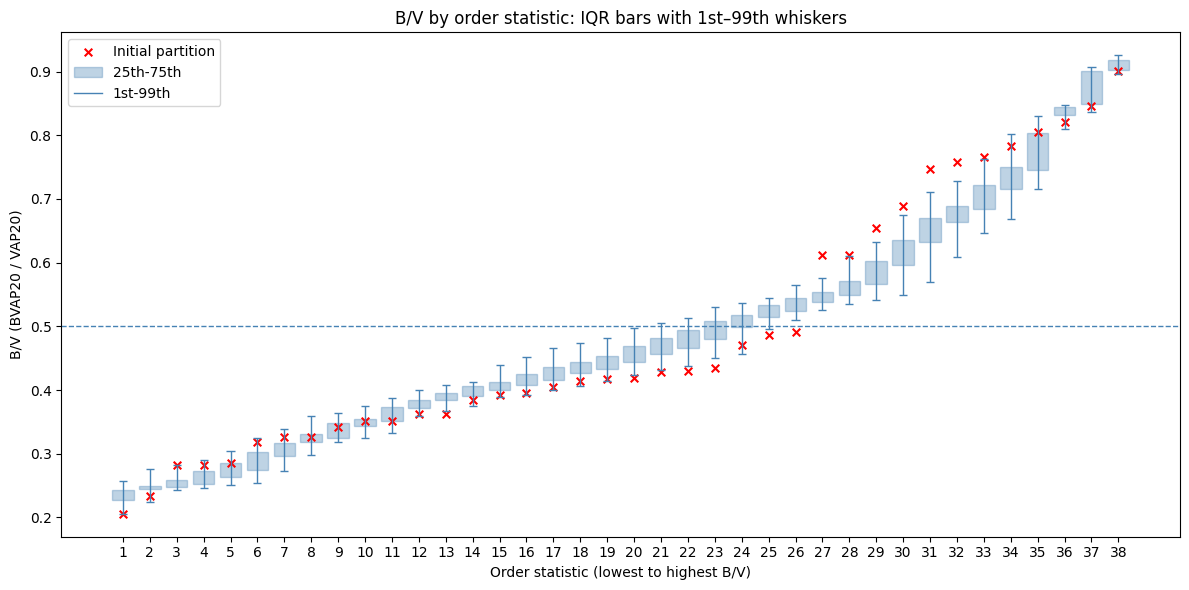

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Brute-force compute sorted B/V ratios for each assignment
ratios_per_assignment = []

# Parts are 1-indexed in this dataset
n_parts = len(tx_partition)
parts_list = list(range(1, n_parts + 1))

for assignment in assignment_list:
    # part -> [B, V]
    part_sums = {part: [0.0, 0.0] for part in parts_list}
    for node, part in assignment.mapping.items():
        data = modified_tx_graph.nodes[node]
        b = data.get("BVAP20", 0) or 0
        h = data.get("HVAP20", 0) or 0
        v = data.get("VAP20", 0) or 0
        part_sums[part][0] += b + h
        part_sums[part][1] += v

    ratios = []
    for b, v in part_sums.values():
        ratios.append(b / v if v else np.nan)

    ratios = np.array(ratios, dtype=float)
    ratios = np.sort(ratios)
    ratios_per_assignment.append(ratios)

ratios_matrix = np.vstack(ratios_per_assignment)

q01 = np.nanpercentile(ratios_matrix, 1, axis=0)
q25 = np.nanpercentile(ratios_matrix, 25, axis=0)
q75 = np.nanpercentile(ratios_matrix, 75, axis=0)
q99 = np.nanpercentile(ratios_matrix, 99, axis=0)

x = np.arange(1, ratios_matrix.shape[1] + 1)

# Compute initial partition ratios for overlay
init_sums = {part: [0.0, 0.0] for part in parts_list}
for node, part in tx_partition.assignment.mapping.items():
    data = modified_tx_graph.nodes[node]
    b = data.get("BVAP20", 0) or 0
    h = data.get("HVAP20", 0) or 0
    v = data.get("VAP20", 0) or 0
    init_sums[part][0] += b + h
    init_sums[part][1] += v

init_ratios = []
for b, v in init_sums.values():
    init_ratios.append(b / v if v else np.nan)
init_ratios = np.sort(np.array(init_ratios, dtype=float))

plt.figure(figsize=(12, 6))

bar_heights = q75 - q25
plt.bar(x, bar_heights, bottom=q25, width=0.8, alpha=0.35, color="steelblue", edgecolor="steelblue", label="25th-75th")

for xi, lo, hi in zip(x, q01, q99):
    plt.vlines(xi, lo, hi, colors="steelblue", linewidth=1)
    plt.hlines([lo, hi], xi - 0.15, xi + 0.15, colors="steelblue", linewidth=1)

plt.scatter(x, init_ratios, color="red", marker="x", s=30, label="Initial partition")

plt.axhline(0.5, color="steelblue", linestyle="--", linewidth=1)

plt.xticks(x)

plt.xlabel("Order statistic (lowest to highest B/V)")
plt.ylabel("B/V (BVAP20 / VAP20)")
plt.title("B/V by order statistic: IQR bars with 1st–99th whiskers")

whisker_handle = Line2D([0], [0], color="steelblue", linewidth=1, label="1st-99th")
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(whisker_handle)
labels.append("1st-99th")
plt.legend(handles, labels)

plt.tight_layout()
plt.show()

In the above plot, we see that our random walk (which wasn't even trying to optimize the number of majority-minority districts) typically produces at least two more majority-minority districts than the enacted plan.

This is some (very oversimplified) evidence to show that the map passes the so-called *Gingles Criterion*, and that our plaintiffs might have legal ground to contest the map.

In practice, it is typical to consider that a minority group is competitive in a district if they have above $\approx.37$ of the vote share. So we can run a dedicated chain to try to optimize the number of districts that are competitive for Black & Latino voters: 

In [8]:
from functools import partial
import numpy as np
from gerrychain import Partition
from gerrychain import constraints, proposals, updaters
from gerrychain.optimization import Gingleator
from gerrychain.accept import always_accept
from gerrychain.constraints import contiguous

# Gingleator setup for BVAP/VAP majority-minority optimization
POPCOL = "VAP20"
MINCOL = "BVAP20_PLUS_HVAP20"
EPS = 0.08

# Updaters: total VAP and BVAP totals per district
chain_updaters = {
    "population": updaters.Tally(POPCOL, alias="population"),
    "vap": updaters.Tally(POPCOL, alias="vap"),
    "bvap": updaters.Tally("BVAP20", alias="bvap"),
    "hvap": updaters.Tally("HVAP20", alias="hvap"),
    # Combined BVAP + HVAP updater per district
    "bhvap": lambda part: {k: part["bvap"][k] + part["hvap"][k] for k in part.parts.keys()},
}

# Start from the current plan but add needed updaters
initial_partition = Partition(
    modified_tx_graph,
    assignment=starting_partition.assignment,
    updaters=chain_updaters,
)

TOTPOP = sum(modified_tx_graph.nodes[n][POPCOL] for n in modified_tx_graph.nodes())
NUM_DISTS = len(initial_partition)

proposal = partial(
    proposals.recom,
    pop_col=POPCOL,
    pop_target=TOTPOP / NUM_DISTS,
    epsilon=EPS,
    node_repeats=10,
)

# Population balance constraint (uses the "population" updater)
chain_constraints = [
    contiguous,
    constraints.within_percent_of_ideal_population(initial_partition, EPS, pop_key="population"),
]

# Gingleator: compute minority percentage from bvap/vap updaters
# score_function defaults to a majority-minority count; here we use the built-in helper
# that rewards partial districts in the direction of the threshold.
gingles = Gingleator(
    proposal=proposal,
    constraints=chain_constraints,
    initial_state=initial_partition,
    minority_pop_col="bhvap",
    total_pop_col="vap",
    score_function=Gingleator.reward_partial_dist,
    threshold=0.37
)

# Run a short-bursts optimization (keep only the best plan from each burst)
num_bursts = 500
steps_per_burst = 10

best_parts_per_burst = []
best_scores = []

start_part = initial_partition
for _ in range(num_bursts):
    burst_chain = MarkovChain(proposal, chain_constraints, always_accept, start_part, steps_per_burst)
    best_part = start_part
    best_score = gingles.score(best_part)

    for part in burst_chain:
        s = gingles.score(part)
        if s > best_score:
            best_part = part
            best_score = s

    best_parts_per_burst.append(best_part)
    best_scores.append(best_score)
    start_part = best_part

best_scores[-1], len(best_parts_per_burst)

(35.30414738036338, 500)

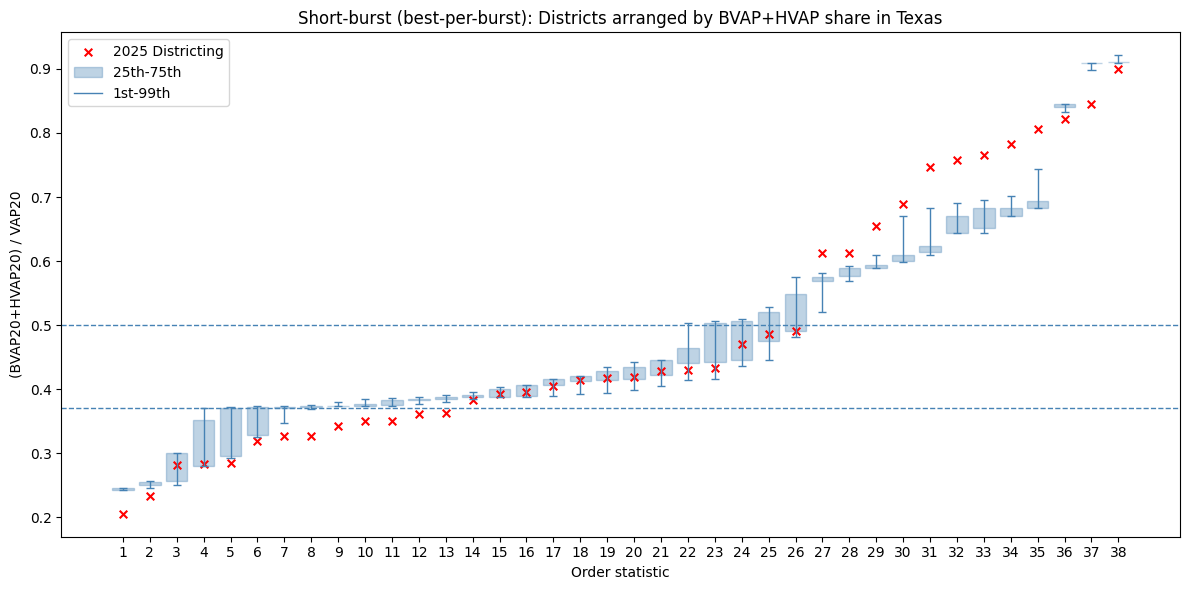

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Build assignments list from the best plan of each burst
short_burst_assignments = [p.assignment for p in best_parts_per_burst]

# Parts are 1-indexed in this dataset
n_parts = len(tx_partition)
parts_list = list(range(1, n_parts + 1))


def plot_order_stat_bars(assignments, num_col, denom_col, title, ylabel, ref_line=None):
    ratios_per_assignment = []
    for assignment in assignments:
        part_sums = {part: [0.0, 0.0] for part in parts_list}
        for node, part in assignment.mapping.items():
            data = modified_tx_graph.nodes[node]
            num = (data.get("BVAP20", 0) or 0) + (data.get("HVAP20", 0) or 0) if num_col == "BVAP20_PLUS_HVAP20" else (data.get(num_col, 0) or 0)
            den = data.get(denom_col, 0) or 0
            part_sums[part][0] += num
            part_sums[part][1] += den

        ratios = []
        for num, den in part_sums.values():
            ratios.append(num / den if den else np.nan)

        ratios = np.array(ratios, dtype=float)
        ratios = np.sort(ratios)
        ratios_per_assignment.append(ratios)

    ratios_matrix = np.vstack(ratios_per_assignment)

    q01 = np.nanpercentile(ratios_matrix, 1, axis=0)
    q25 = np.nanpercentile(ratios_matrix, 25, axis=0)
    q75 = np.nanpercentile(ratios_matrix, 75, axis=0)
    q99 = np.nanpercentile(ratios_matrix, 99, axis=0)

    x = np.arange(1, ratios_matrix.shape[1] + 1)

    # Initial partition ratios for overlay
    init_sums = {part: [0.0, 0.0] for part in parts_list}
    for node, part in tx_partition.assignment.mapping.items():
        data = modified_tx_graph.nodes[node]
        num = (data.get("BVAP20", 0) or 0) + (data.get("HVAP20", 0) or 0) if num_col == "BVAP20_PLUS_HVAP20" else (data.get(num_col, 0) or 0)
        den = data.get(denom_col, 0) or 0
        init_sums[part][0] += num
        init_sums[part][1] += den

    init_ratios = []
    for num, den in init_sums.values():
        init_ratios.append(num / den if den else np.nan)
    init_ratios = np.sort(np.array(init_ratios, dtype=float))

    plt.figure(figsize=(12, 6))

    bar_heights = q75 - q25
    plt.bar(x, bar_heights, bottom=q25, width=0.8, alpha=0.35, color="steelblue", edgecolor="steelblue", label="25th-75th")

    for xi, lo, hi in zip(x, q01, q99):
        plt.vlines(xi, lo, hi, colors="steelblue", linewidth=1)
        plt.hlines([lo, hi], xi - 0.15, xi + 0.15, colors="steelblue", linewidth=1)

    plt.scatter(x, init_ratios, color="red", marker="x", s=30, label="2025 Districting")

    if ref_line is not None:
        plt.axhline(ref_line, color="steelblue", linestyle="--", linewidth=1)
    plt.axhline(0.5, color="steelblue", linestyle="--", linewidth=1)
    plt.xticks(x)

    plt.xlabel("Order statistic")
    plt.ylabel(ylabel)
    plt.title(title)

    whisker_handle = Line2D([0], [0], color="steelblue", linewidth=1, label="1st-99th")
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.append(whisker_handle)
    labels.append("1st-99th")
    plt.legend(handles, labels)

    plt.tight_layout()
    plt.show()


# B/V over best-of-burst chain
plot_order_stat_bars(
    short_burst_assignments,
    num_col="BVAP20_PLUS_HVAP20",
    denom_col="VAP20",
    title="Short-burst (best-per-burst): Districts arranged by BVAP+HVAP share in Texas",
    ylabel="(BVAP20+HVAP20) / VAP20",
    ref_line=0.37,
)


Usually, the above shows that we can draw a plan that makes 3 to 6 more competitive districts for minority groups than the enacted one.

And we can also run the same chain with a threshold of .5 rather than .37, if we want to make a strong case that we pass the Gingles criteria:

In [10]:
from functools import partial
import numpy as np
from gerrychain import Partition
from gerrychain import constraints, proposals, updaters
from gerrychain.optimization import Gingleator
from gerrychain.accept import always_accept
from gerrychain.constraints import contiguous

gingles = Gingleator(
    proposal=proposal,
    constraints=chain_constraints,
    initial_state=initial_partition,
    minority_pop_col="bhvap",
    total_pop_col="vap",
    score_function=Gingleator.reward_partial_dist,
    threshold=0.5 # THIS IS THE ONLY THING THAT CHANGES
)

# Run a short-bursts optimization (keep only the best plan from each burst)
num_bursts = 500
steps_per_burst = 10

best_parts_per_burst = []
best_scores = []

start_part = initial_partition
for _ in range(num_bursts):
    burst_chain = MarkovChain(proposal, chain_constraints, always_accept, start_part, steps_per_burst)
    best_part = start_part
    best_score = gingles.score(best_part)

    for part in burst_chain:
        s = gingles.score(part)
        if s > best_score:
            best_part = part
            best_score = s

    best_parts_per_burst.append(best_part)
    best_scores.append(best_score)
    start_part = best_part

best_scores[-1], len(best_parts_per_burst)

(23.421527605820657, 500)

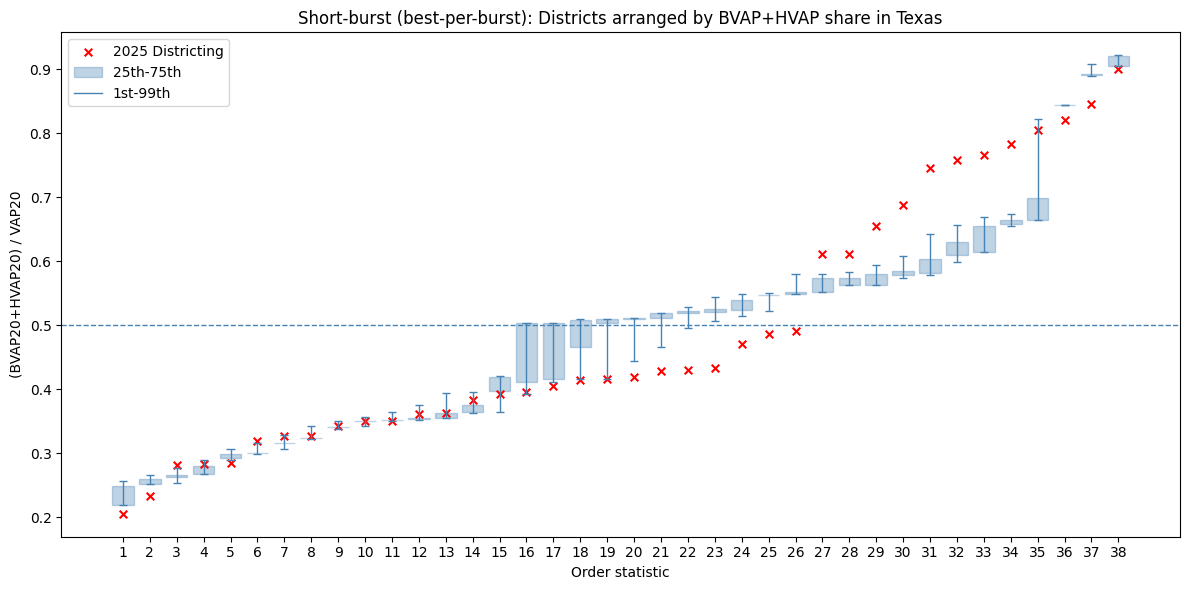

In [12]:
short_burst_assignments = [p.assignment for p in best_parts_per_burst]

plot_order_stat_bars(
    short_burst_assignments,
    num_col="BVAP20_PLUS_HVAP20",
    denom_col="VAP20",
    title="Short-burst (best-per-burst): Districts arranged by BVAP+HVAP share in Texas",
    ylabel="(BVAP20+HVAP20) / VAP20",
    #ref_line=0.37,
)